In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# A preferred plotting visualisation format
plt.style.use(["seaborn-notebook", "seaborn-darkgrid"])
sns.set_palette("flare")
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["xtick.major.size"] = 2
mpl.rcParams["ytick.major.size"] = 2
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["font.family"] = "sans"


### Neuron Activity

Implementation for a single neuron and assessing the behaviour across typical hyperparameters differing between types. This bifurication analysis will denote a single neuron with the following first-order differential equations and updates:

$$
\begin{align}
\frac{dv}{dt} &= 0.04v^2 + 5v + 140 -u + I \\
\frac{du}{dt} &= a(bv-u) \\
\text{firing:\quad if } v &\geq 30 \text{ mV, then } \begin{cases} v \leftarrow c \\ u \leftarrow u + d \end{cases}
\end{align}
$$

The chosen parameters for each neuron are described in the following table:

| Neuron | a    | b    | c    | d    |
| ------ | ---- | ---- | ---- | ---- |
| RS     | 0.02 | 0.20 | -65  | 8    |
| IB     | 0.02 | 0.20 | -55  | 4    |
| CH     | 0.02 | 0.20 | -50  | 2    |
| FS     | 0.10 | 0.20 | -65  | 2    |
| TC     | 0.02 | 0.25 | -65  | 0.05 |
| RZ     | 0.10 | 0.26 | -65  | 2    |
| LTS    | 0.02 | 0.25 | -65  | 2    |



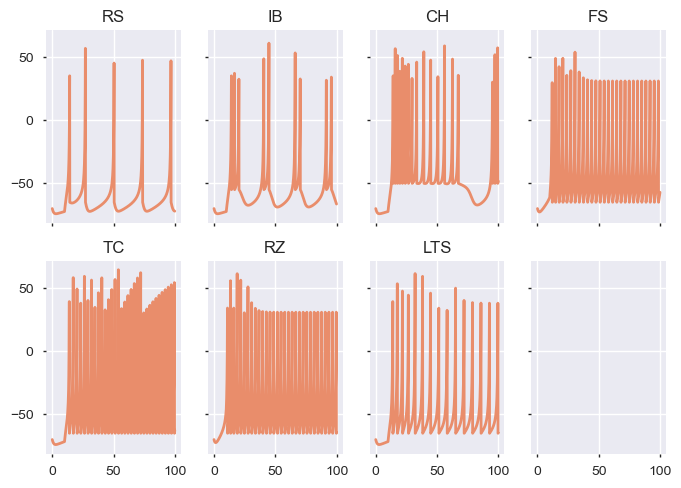

In [168]:
# Simple neuron model
class Neuron(BaseModel):
    name: str
    a: float
    b: float
    c: float
    d: float

    def step_v(self, v: float, u: float, I) -> float:
        return 0.04 * (v**2) + 5 * v + 150 - u + I

    def step_u(self, v: float, u: float, I) -> float:
        return self.a * (self.b * v - u)

    def simulate_spiking(
        self,
        u_start: float,
        v_start: float,
        I: float,
        ms_timestemp: float = 0.1,
        ms_total: int = 1000,
    ) -> pd.DataFrame:
        """
        Simulate spiking behaviour of the neuron with the given hyperparameters using
        Izhikevich's differential equations for u, v updates.

        Args:
            u_start (float): Starting value for u.
            v_start (float): Starting value for v.
            I (float): Pre-synaptic input current.
            ms_timestemp (float, optional): Simulation timestemp. Defaults to 0.1.
            ms_total (int, optional): Simulation total time. Defaults to 1000.

        Returns:
            pd.DataFrame: DataFrame of simulation results. Rows correspond to time steps
                with columns for u, v and simulation time.
        """
        DELAY = 10
        total_steps = int(ms_total / ms_timestemp)
        u_data = np.zeros(total_steps, dtype=np.float32)
        v_data = np.zeros(total_steps, dtype=np.float32)
        t_data = np.zeros(total_steps, dtype=np.float32)
        u_data[0] = u_start
        v_data[0] = v_start

        for i in range(1, total_steps):
            if t_data[i - 1] < DELAY:
                I_s = 0
            else:
                I_s = I
            if v_data[i - 1] >= 30:
                v_data[i] = self.c
                u_data[i] = u_data[i - 1] + self.d
            else:
                v_data[i] = v_data[i - 1] + ms_timestemp * self.step_v(
                    v_data[i - 1], u_data[i - 1], I_s
                )
                u_data[i] = u_data[i - 1] + ms_timestemp * self.step_u(
                    v_data[i - 1], u_data[i - 1], I_s
                )
            t_data[i] = t_data[i - 1] + ms_timestemp

        return pd.DataFrame(
            {
                "Time": t_data,
                "v": v_data,
                "u": u_data,
            }
        )


neurons = [
    Neuron(name="Regular Spiking (RS)", a=0.02, b=0.20, c=-65, d=8.00),
    Neuron(name="IB", a=0.02, b=0.20, c=-55, d=4.00),
    Neuron(name="CH", a=0.02, b=0.20, c=-50, d=2.00),
    Neuron(name="FS", a=0.10, b=0.20, c=-65, d=2.00),
    Neuron(name="TC", a=0.02, b=0.25, c=-65, d=0.05),
    Neuron(name="RZ", a=0.10, b=0.26, c=-65, d=2.00),
    Neuron(name="LTS", a=0.02, b=0.25, c=-65, d=2.00),
]

fig, ax = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
for i in range(len(neurons)):
    col = i % 4
    row = i // 4
    data = neurons[i].simulate_spiking(0, -70, 10, 0.1, 100)
    ax[(row, col)].plot(data.Time, data.v)
    ax[(row, col)].set_title(neurons[i].name)

### Coevolution Model

> Requires a detailed description

> Requires an overview of what is being implemented

Pydantic implementation is used for this model to make the depths of type checking more 
refined and well represented in code, rather than stricter and less flexible definitions 
of `dataclasses` constructors and post initialisation functionality.